<a href="https://colab.research.google.com/github/yc2454/gym-futbol/blob/master/colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load 
Load our project and install some packages

In [1]:
! git clone https://github.com/yc2454/gym-futbol.git

Cloning into 'gym-futbol'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 1555 (delta 40), reused 60 (delta 21), pack-reused 1464
Receiving objects: 100% (1555/1555), 95.30 MiB | 25.17 MiB/s, done.
Resolving deltas: 100% (826/826), done.


In [2]:
%cd /content/gym-futbol/

/content/gym-futbol


In [3]:
! pip install -e .

Obtaining file:///content/gym-futbol
     |████████████████████████████████| 542kB 8.6MB/s 
  Running setup.py develop for gym-futbol


In [4]:
%tensorflow_version 1.14
! pip install keras tensorflow gym numpy stable-baselines[mpi]==2.10.0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
     |████████████████████████████████| 256kB 7.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=225b232fd61ec445049f145031d229f836e3d9d753a94096f6e83d45b5e1bc59
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


# import packages

In [5]:
import gym
import gym_futbol, random
import numpy as np

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import pymunk
from pymunk.vec2d import Vec2d
import pymunk.matplotlib_util

Loading chipmunk for Linux (64bit) [/usr/local/lib/python3.6/dist-packages/pymunk/libchipmunk.so]


In [0]:
def colab_render(env):
      ob = env.reset()
      done = False
      total_reward = 0
      while not done:
          action = np.reshape(env.random_action(), -1)
          ob, reward, done, info = env.step(action)

          plt.clf()
          title_str = ("reward : " + str(reward))
          padding = 5
          ax = plt.axes(xlim=(0 - padding, env.width + padding), ylim=(0 - padding, env.height + padding))
          ax.set_aspect("equal")
          o = pymunk.matplotlib_util.DrawOptions(ax)
          env.space.debug_draw(o)
          plt.title(title_str, loc = 'left')
          display.display(plt.gcf())
          display.clear_output(wait=True)

          total_reward += reward
      return total_reward

# Test Envs
Both side take random actions 

## 2 player vs 2 player

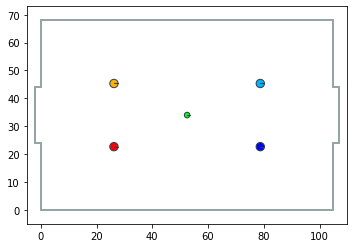

In [7]:
env = gym.make("Futbol2v2-v1")
env.render()

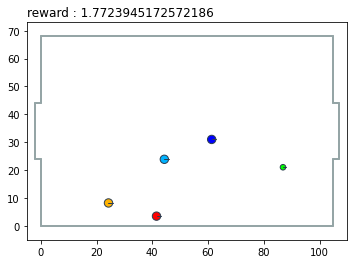

In [8]:
# Both side take random actions 
total_reward = colab_render(env)

## 5 player vs 5 player

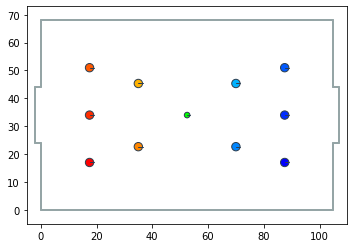

In [9]:
env = gym.make("Futbol5v5-v1")
env.render()

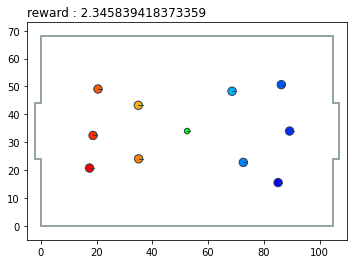

In [10]:
# Both side take random actions 
total_reward = colab_render(env)

## 10 player vs 10 player

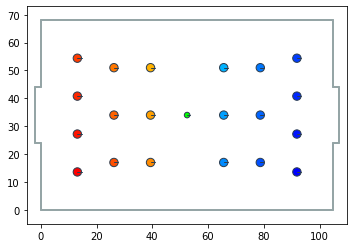

In [11]:
env = gym.make("Futbol-v1")
env.render()

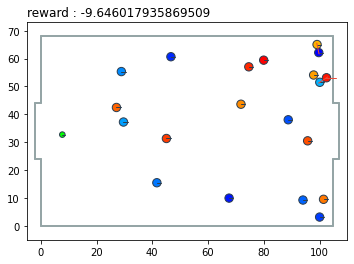

In [12]:
# Both side take random actions 
total_reward = colab_render(env)

# Load trained model

## import stable baselines

In [13]:
import os, time, gym
from stable_baselines.common.policies import MlpPolicy, FeedForwardPolicy, register_policy
from stable_baselines.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines.common import make_vec_env
from stable_baselines import PPO2
from stable_baselines.bench import Monitor
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.callbacks import EvalCallback
from stable_baselines.common.evaluation import evaluate_policy
%load_ext tensorboard

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
def test_model(env, model, vis=False):
      ob = env.reset()
      done = False
      total_reward = 0
      while not done:
          action, _states = model.predict(ob)
          ob, reward, done, info = env.step(action)
          if vis:
                plt.clf()
                title_str = "reward : " + str(reward)
                padding = 5
                ax = plt.axes(xlim=(0 - padding, env.width + padding), ylim=(0 - padding, env.height + padding))
                ax.set_aspect("equal")
                o = pymunk.matplotlib_util.DrawOptions(ax)
                env.space.debug_draw(o)
                plt.title(title_str, loc = 'left')
                display.display(plt.gcf())
                display.clear_output(wait=True)
          total_reward += reward
      return total_reward

## load 
As we mostly done the training process in 2v2 setup. we provide 9 model we trained in the hyperparameter training process. <br>
Test detail can be found in https://drive.google.com/open?id=1Rc7JftOcVXrOk65zqB86BLFv2aGutbf2.

In [15]:
%cd /content/gym-futbol

/content/gym-futbol


In [0]:
model = PPO2.load("trained_model_2v2/model1") # model 0 - 9

4465.857612852453

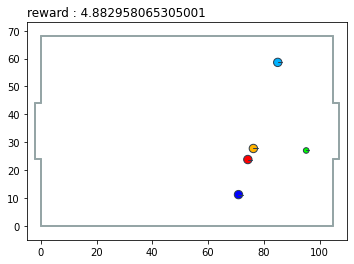

In [20]:
env = gym.make("Futbol2v2-v1")
test_model(env, model, vis=True)

In [21]:
env = gym.make("Futbol2v2-v1")
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:2027.02 +/- 1519.25


# Training

In [0]:
%cd /content/

In [0]:
# Custom MLP policy 
class CustomPolicy(FeedForwardPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomPolicy, self).__init__(*args, **kwargs,
                                           net_arch=[256, 256, dict(pi=[128, 128],
                                                                    vf=[128, 128])],
                                           feature_extraction="mlp")

In [0]:
# Separate evaluation env
eval_env = gym.make("Futbol2v2-v1")
# Use deterministic actions for evaluation
eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/',
                             log_path='./logs/', eval_freq=1000, n_eval_episodes = 5,
                             deterministic=True, render=False)

In [0]:
log_dir = "/tmp/gym/{}".format(int(time.time()))
os.makedirs(log_dir, exist_ok=True)

num_envs = 8
env = gym.make("Futbol2v2-v1")
env = Monitor(env, log_dir, allow_early_resets=True)
env = DummyVecEnv([lambda: env] * num_envs)

model = PPO2(CustomPolicy, env, verbose=1, tensorboard_log="/content/PPO2_Futbol2v2_tensorboard/")

In [0]:
env = gym.make("Futbol2v2-v1")
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

In [0]:
# model training
model.learn(total_timesteps=5 * 10**4, reset_num_timesteps=False)

In [0]:
# model training and save the best model
model.learn(total_timesteps=5 * 10**4, reset_num_timesteps=False, callback=eval_callback)

812.4024796183503

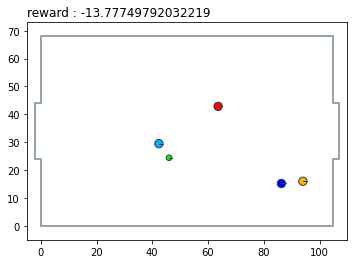

In [32]:
env = gym.make("Futbol2v2-v1")
test_model(env, model, vis=True)

In [0]:
env = gym.make("Futbol2v2-v1")
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

In [0]:
# visualize the saved training process
%tensorboard --logdir /content/PPO2_Futbol2v2_tensorboard/

# Load Best
The best model saved by the callback function. Be careful about the correct path.

In [0]:
best_model = PPO2.load("logs/best_model")

680.8950513729543

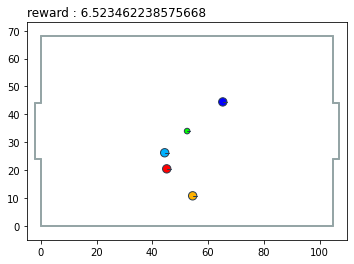

In [36]:
env = gym.make("Futbol2v2-v1")
test_model(env, best_model, vis=True)

In [0]:
env = gym.make("Futbol2v2-v1")
mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=10)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")